In [1]:

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
!pip install xgboost lightgbm
import xgboost as xgb
import lightgbm as lgb


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
DATA_PATH = "C:\\Users\\User\\Desktop\\end-to-end_ml_project\\FPL_best_xi\\data\\processed\\player_features.csv"
MODELS_DIR = r"C:\Users\User\Desktop\end-to-end_ml_project\FPL_best_xi\src\models"
os.makedirs(MODELS_DIR, exist_ok=True)
RANDOM_STATE = 42


In [4]:
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
print("Seasons:", sorted(df['season'].unique()))

Loaded: (68240, 40)
Seasons: ['2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25', '2025-26']


In [5]:
df = df.dropna(subset=['total_points']).reset_index(drop=True)

In [6]:
seasons = sorted(df['season'].unique(), key=lambda s: s)
print("Seasons (sorted):", seasons)


Seasons (sorted): ['2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25', '2025-26']


In [7]:
if len(seasons) < 3:
    raise ValueError("Need at least 3 seasons for train/val/test split. Add more historical seasons.")
test_season = seasons[-1]
val_season = seasons[-2]
train_seasons = seasons[:-2]

print(f"Train seasons: {train_seasons}\nVal season: {val_season}\nTest season: {test_season}")


Train seasons: ['2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
Val season: 2024-25
Test season: 2025-26


In [8]:
train_df = df[df['season'].isin(train_seasons)].reset_index(drop=True)
val_df   = df[df['season'] == val_season].reset_index(drop=True)
test_df  = df[df['season'] == test_season].reset_index(drop=True)


In [9]:
exclude = [
    'name', 'season', 'gameweek', 'total_points',  # total_points is the target
    # raw identifiers that are not predictive or will be encoded separately
]


In [10]:
for c in ['position', 'team']:
    # we'll one-hot encode or label encode them
    if c not in df.columns:
        print(f"Warning: expected column {c} not found in dataset")


In [11]:
feature_cols = [c for c in df.columns if c not in exclude]
# Optionally remove some columns you don't want as inputs (e.g., 'value' you might keep)
print("Initial feature count:", len(feature_cols))

Initial feature count: 36


In [12]:
cat_cols = [c for c in ['position', 'team'] if c in feature_cols]
num_cols = [c for c in feature_cols if c not in cat_cols]


In [13]:
print("Numeric features:", len(num_cols))
print("Categorical features:", cat_cols)


Numeric features: 34
Categorical features: ['position', 'team']


In [14]:
transformer = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")  # passthrough numeric features


In [15]:
X_train_raw = train_df[feature_cols]
X_val_raw   = val_df[feature_cols]
X_test_raw  = test_df[feature_cols]


In [16]:
transformer.fit(X_train_raw)
X_train = transformer.transform(X_train_raw)
X_val = transformer.transform(X_val_raw)
X_test = transformer.transform(X_test_raw)


In [17]:
y_train = train_df['total_points'].values
y_val   = val_df['total_points'].values
y_test  = test_df['total_points'].values


In [18]:
print("Transformed shapes:", X_train.shape, X_val.shape, X_test.shape)

Transformed shapes: (54221, 67) (11566, 67) (2453, 67)


In [19]:
print("\nTraining XGBoost...")

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": RANDOM_STATE,
    "tree_method": "hist"
}

xgb_watchlist = [(dtrain, "train"), (dval, "val")]
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=5000,
    early_stopping_rounds=50,
    evals=xgb_watchlist,
    verbose_eval=50
)



Training XGBoost...
[0]	train-mae:2.09795	val-mae:2.06788
[50]	train-mae:0.31424	val-mae:0.28109
[100]	train-mae:0.16192	val-mae:0.14223
[150]	train-mae:0.13614	val-mae:0.12474
[200]	train-mae:0.12193	val-mae:0.11576
[250]	train-mae:0.11298	val-mae:0.11109
[300]	train-mae:0.10503	val-mae:0.10867
[350]	train-mae:0.09960	val-mae:0.10826
[400]	train-mae:0.09487	val-mae:0.10860
[404]	train-mae:0.09470	val-mae:0.10858


In [20]:
joblib.dump(xgb_model, os.path.join(MODELS_DIR, "xgb_model.joblib"))
joblib.dump(transformer, os.path.join(MODELS_DIR, "preprocessor.joblib"))
print("Saved XGBoost and preprocessor to", MODELS_DIR)


Saved XGBoost and preprocessor to C:\Users\User\Desktop\end-to-end_ml_project\FPL_best_xi\src\models


In [21]:
print("\nTraining LightGBM...")
from lightgbm import early_stopping, log_evaluation

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

lgb_params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": RANDOM_STATE
}

lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=5000,
    valid_sets=[lgb_train, lgb_val],
   callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)



Training LightGBM...


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 54221, number of used features: 67
[LightGBM] [Info] Start training from score 2.893362
Training until validation scores don't improve for 50 rounds
[50]	training's l1: 0.262506	valid_1's l1: 0.225819
[100]	training's l1: 0.124956	valid_1's l1: 0.11942
[150]	training's l1: 0.106113	valid_1's l1: 0.111658
[200]	training's l1: 0.0958714	valid_1's l1: 0.109717
Early stopping, best iteration is:
[193]	training's l1: 0.0968202	valid_1's l1: 0.109271


In [22]:

joblib.dump(lgb_model, os.path.join(MODELS_DIR, "lgb_model.joblib"))
print("Saved LightGBM to", MODELS_DIR)


Saved LightGBM to C:\Users\User\Desktop\end-to-end_ml_project\FPL_best_xi\src\models


In [23]:
print("\nEvaluation on test set...")

#  Predict with XGBoost (version-safe)
dtest = xgb.DMatrix(X_test)
best_iter = getattr(xgb_model, "best_iteration", None)

if best_iter is not None:
    # XGBoost >=1.6 uses iteration_range for safe prediction
    y_pred_xgb = xgb_model.predict(dtest, iteration_range=(0, best_iter))
else:
    # fallback if early stopping not used or version mismatch
    y_pred_xgb = xgb_model.predict(dtest)

# ✅ Predict with LightGBM (version-safe)
best_iter_lgb = getattr(lgb_model, "best_iteration", None)
if best_iter_lgb is not None:
    y_pred_lgb = lgb_model.predict(X_test, num_iteration=best_iter_lgb)
else:
    y_pred_lgb = lgb_model.predict(X_test)

# ✅ Evaluation function
def eval_metrics(y_true, y_pred, model_name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"[{model_name}] MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    return {"mae": mae, "rmse": rmse, "r2": r2}

# ✅ Evaluate both models
metrics_xgb = eval_metrics(y_test, y_pred_xgb, "XGBoost")
metrics_lgb = eval_metrics(y_test, y_pred_lgb, "LightGBM")

print("\n📊 Evaluation complete")


Evaluation on test set...
[XGBoost] MAE: 0.2930 | RMSE: 0.6879 | R²: 0.9470
[LightGBM] MAE: 0.2977 | RMSE: 0.7025 | R²: 0.9448

📊 Evaluation complete


In [24]:
test_df_out = test_df.copy().reset_index(drop=True)
test_df_out['pred_xgb'] = y_pred_xgb
test_df_out['pred_lgb'] = y_pred_lgb
test_df_out.to_csv(os.path.join(MODELS_DIR, "test_predictions_with_metadata.csv"), index=False)
print("Saved test predictions to models/test_predictions_with_metadata.csv")

Saved test predictions to models/test_predictions_with_metadata.csv


In [25]:
ohe = None
cat_feature_names = []
if hasattr(transformer, "transformers_"):
    # find categorical transformer
    for name, trans, cols in transformer.transformers_:
        if name == "cat":
            ohe = trans
            cat_cols_list = cols if isinstance(cols, (list, tuple)) else [cols]
            break

if ohe is not None:
    # get categories
    cats = ohe.categories_
    cat_names = []
    for col_name, cat_values in zip(cat_cols_list, cats):
        cat_names += [f"{col_name}__{val}" for val in cat_values]
    # remainder columns are numeric columns (passed through). Determine their order:
    remainder_cols = [c for c in feature_cols if c not in cat_cols]
    feature_names = cat_names + remainder_cols
else:
    feature_names = feature_cols



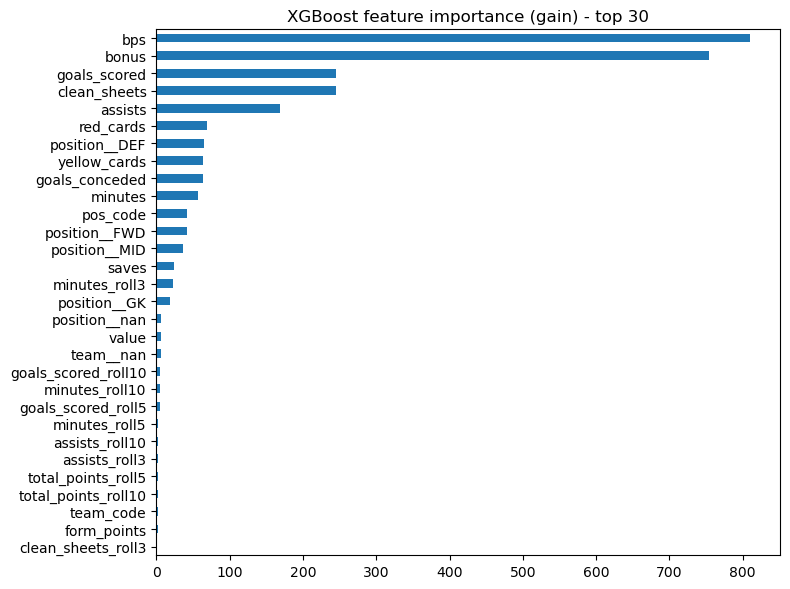

In [26]:
# XGBoost importance
try:
    xgb_imp = xgb_model.get_score(importance_type='gain')
    xgb_imp_series = pd.Series({k: v for k, v in xgb_imp.items()})
    # XGBoost uses names like f0, f1... map to our feature_names
    # Map f{index} -> feature_names[index]
    xgb_map = {}
    for k, v in xgb_imp_series.items():
        idx = int(k.replace('f', ''))
        if idx < len(feature_names):
            xgb_map[feature_names[idx]] = v
    xgb_imp_df = pd.Series(xgb_map).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,6))
    xgb_imp_df[::-1].plot.barh()
    plt.title("XGBoost feature importance (gain) - top 30")
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, "xgb_feature_importance.png"))
    plt.show()
except Exception as e:
    print("XGBoost importance failed:", e)



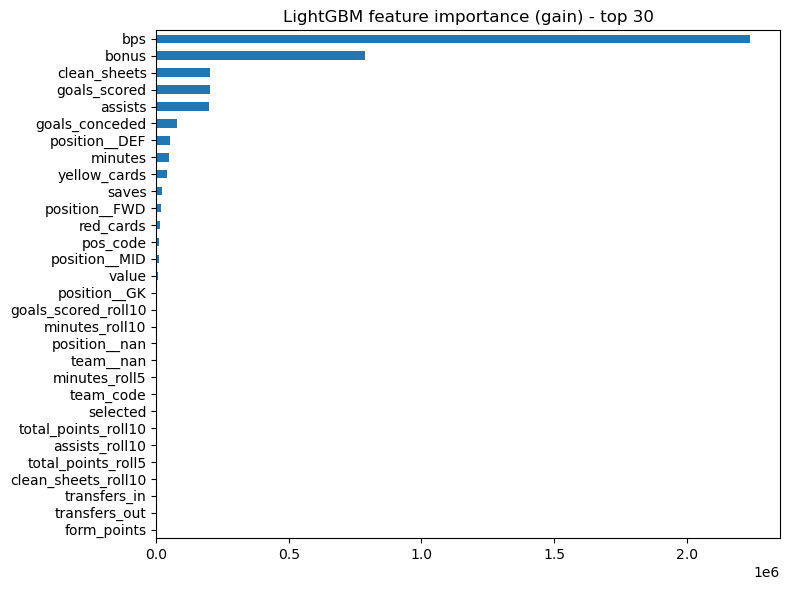

In [27]:
# LightGBM importance (split or gain)
try:
    lgb_imp = lgb_model.feature_importance(importance_type='gain')
    # lgb features are ordered 0..n
    lgb_imp_series = pd.Series(lgb_imp, index=feature_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,6))
    lgb_imp_series[::-1].plot.barh()
    plt.title("LightGBM feature importance (gain) - top 30")
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, "lgb_feature_importance.png"))
    plt.show()
except Exception as e:
    print("LightGBM importance failed:", e)

In [28]:
metrics = {
    "xgb": metrics_xgb,
    "lgb": metrics_lgb,
    "config": {
        "train_seasons": train_seasons,
        "val_season": val_season,
        "test_season": test_season
    }
}
import json
with open(os.path.join(MODELS_DIR, "metrics_summary.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Save models in joblib format already done; also save plain files if desired
print("\nAll done. Models and artifacts saved in:", MODELS_DIR)


All done. Models and artifacts saved in: C:\Users\User\Desktop\end-to-end_ml_project\FPL_best_xi\src\models
